### Let's use a benchmark BEM problem to test if the current functions are working correctly.

In [1]:
%matplotlib widget

In [2]:
import numpy as np
from numpy import log,  sin, cos, arctan2, pi, mean, dot
from numpy.linalg import norm, solve
from scipy.special import roots_legendre,hankel1
from scipy.integrate import quad
import matplotlib.pyplot as plt
import meshio
import gmsh
from add_funs_test import *

---

### Original field (Analytic)

In [48]:
# Screen width and height
upper_grid_size = 1
lower_grid_size = 0
ngrid_pts = 30

grid_vec = np.linspace(lower_grid_size,upper_grid_size,num=ngrid_pts)

X,Y = np.meshgrid(grid_vec,grid_vec)

In [49]:
m = 2
n = 1

L_x = upper_grid_size-lower_grid_size
L_y = upper_grid_size-lower_grid_size

#k = np.sqrt( (m*np.pi/L_x)**2 + (n*np.pi/L_y)**2 )
k = 2

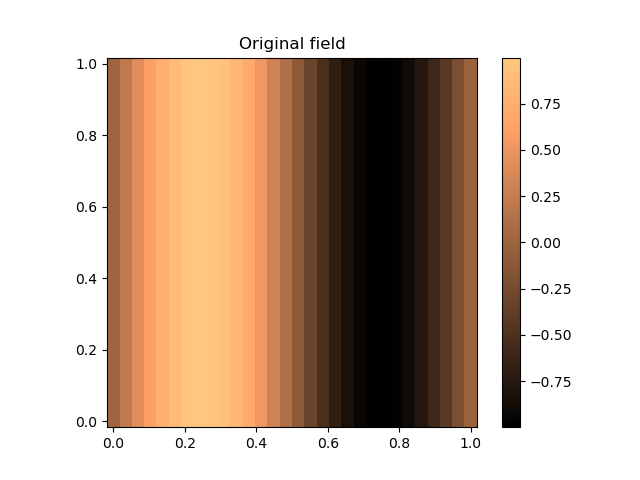

In [50]:
# Define the first field
def ui_fun(x, y, k, m, n, L_x, L_y):
    field = np.sin( m*np.pi*x/L_x ) #* np.sin( n*np.pi*y/L_y )
    return field

# Plot the surface
plt.close('all')

fig, ax = plt.subplots()
plot = ax.pcolormesh(X, Y, ui_fun(X, Y, k, m, n, L_x, L_y), edgecolor="none",cmap="copper")
ax.axis('equal')
ax.set_aspect('equal', 'box')

cbar = fig.colorbar(plot,ax=ax)
plt.title(r"Original field")
plt.show()

---

### BEM alternative

In [51]:
# GMSH mesh geometry generation
create_square_geo(lower_grid_size, upper_grid_size, 0.1, ngrid_pts)

In [52]:
gmsh.initialize()
gmsh.open("simple_square_bound.geo")
gmsh.model.mesh.generate(1)  # 1D mesh
gmsh.write("simple_square_bound.msh")
gmsh.finalize()

In [53]:
fname = "simple_square_bound.msh"
mesh = meshio.read(fname)

In [54]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu = read_geo_gmsh(fname, [0,1,2,3], None)

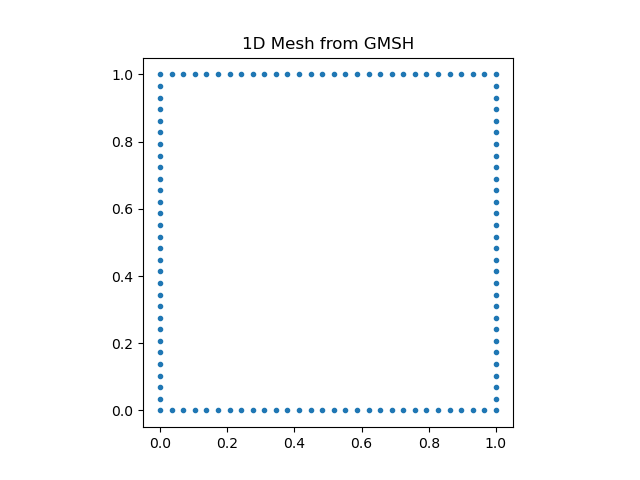

In [55]:
# Plot the surface
plt.close('all')

fig, ax = plt.subplots()
plot = ax.plot(coords[:,0], coords[:,1],".")
ax.axis('equal')

ax.set_aspect('equal', 'box')
plt.title(r"1D Mesh from GMSH")
plt.show()

In [56]:
%%time
Gmat, Hmat = assem(coords,elems,k,"internal")

CPU times: total: 23.3 s
Wall time: 23.5 s


In [ ]:
#from duque_test_funcs import *

In [ ]:
#%%time
#Gmat_d, Hmat_d = assem_duque(coords, elems, k)

In [ ]:
#fig2, ax2 = plt.subplots()
#plot = ax2.imshow(Gmat.real-Gmat_d.real)
#cbar = fig2.colorbar(plot,ax=ax2)
#plt.show()

In [14]:
u_boundary = np.zeros(x_m.shape[0])
u_boundary[id_dir] = ui_fun(x_m, y_m, k, m, n, L_x, L_y)

In [15]:
u_boundary

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -3.94172503e-17,
       -1.17230865e-16, -1.92008262e-16, -2.61812745e-16, -3.24836416e-16,
       -3.79446995e-16, -4.24230095e-16, -4.58025860e-16, -4.79958994e-16,
       -4.89461443e-16, -4.86287098e-16, -4.70518172e-16, -4.42563073e-16,
       -4.03145823e-16, -

In [16]:
q_boundary = solve(Gmat, Hmat.dot(u_boundary))

In [17]:
# Flatten and stack, then exclude boundaries
X_flat = X.flatten()
Y_flat = Y.flatten()
flat_coords = np.column_stack((X_flat, Y_flat))

# Filter out boundary points
ev_coords = flat_coords[
    (flat_coords[:, 0] != upper_grid_size) &
    (flat_coords[:, 0] != lower_grid_size) &
    (flat_coords[:, 1] != upper_grid_size) &
    (flat_coords[:, 1] != lower_grid_size)
]

---


In [18]:
rhs = Hmat @ u_boundary
q_boundary = np.linalg.solve(Gmat, rhs)

#Puntos de evaluación dentro del dominio (ej. cuadrícula)
Xtest, Ytest = np.meshgrid(
    np.linspace(lower_grid_size + 0.01, upper_grid_size - 0.01, 5),
    np.linspace(lower_grid_size + 0.01, upper_grid_size - 0.01, 5)
)
X_flat = Xtest.flatten()
Y_flat = Ytest.flatten()
eval_points = np.column_stack((X_flat, Y_flat))

# Evalúa con el BEM
u_eval_bem = eval_sol(eval_points, coords, elems, u_boundary, q_boundary, k, "internal")

# Evalúa solución analítica


u_exact = ui_fun(eval_points[:,0], eval_points[:,1], k, m, n, L_x, L_y)

# Cálculo del error relativo
error = np.linalg.norm(u_eval_bem - u_exact)
print(f"Error relativo L2: {error:.2e}")


Error relativo L2: 2.81e-01


In [19]:
u_eval_bem.real

array([-3.77236144e-17, -1.01830425e-16, -6.40281476e-17,  9.89015050e-17,
        4.04542301e-16, -8.74815303e-17,  9.77815214e-18,  1.87125851e-16,
        3.10425079e-16,  3.68251285e-16, -7.77125688e-17,  3.13933642e-17,
        1.56060586e-16,  4.61835127e-17, -4.62693210e-16, -3.36281180e-17,
       -3.96493176e-17,  2.01681003e-17, -9.53319424e-18, -1.68845277e-16,
        2.69959297e-18, -1.17111454e-16, -7.45045268e-17,  9.09351983e-17,
        3.32868221e-16])

In [20]:
u_exact

array([ 7.86973885e-03, -3.94264934e-03, -1.53792418e-17,  3.94264934e-03,
       -7.86973885e-03,  1.25271389e-01, -6.27595362e-02, -2.44808502e-16,
        6.27595362e-02, -1.25271389e-01,  1.53488943e-17, -7.68962088e-18,
       -2.99951957e-32,  7.68962088e-18, -1.53488943e-17, -1.25271389e-01,
        6.27595362e-02,  2.44808502e-16, -6.27595362e-02,  1.25271389e-01,
       -7.86973885e-03,  3.94264934e-03,  1.53792418e-17, -3.94264934e-03,
        7.86973885e-03])